In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
import GPy

In [81]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Spec')

In [82]:
x_dat = np.load('abs_SNR_clean_new.npy')
# x_dat = np.reshape(x_dat, -1)[:, None]

In [83]:
x_dat.shape

(6250, 3000)

In [84]:
x_dat

array([[0.0001062, 0.0001064, 0.0001066, ..., 0.000335 , 0.0003347,
        0.0003343],
       [0.0001062, 0.0001064, 0.0001066, ..., 0.000335 , 0.0003347,
        0.0003343],
       [0.0001062, 0.0001064, 0.0001066, ..., 0.000335 , 0.0003347,
        0.0003343],
       ...,
       [0.001556 , 0.001559 , 0.001561 , ..., 0.002974 , 0.002972 ,
        0.002968 ],
       [0.001554 , 0.001555 , 0.001558 , ..., 0.00297  , 0.002968 ,
        0.002964 ],
       [0.001551 , 0.001553 , 0.001555 , ..., 0.002966 , 0.002964 ,
        0.00296  ]], dtype=float16)

In [85]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Param_profile')

In [86]:
y_dat_std = np.load('final_param.npy')

# y_dat = np.reshape(y_dat, -1)[:, None]

# y_dat = y_dat[:10000]

In [87]:
os.chdir('/home/saumya/Documents/FINAL_DATA/Model_data/ICM')

In [88]:
y_A1_T = StandardScaler().fit(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_T = StandardScaler().fit(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_T = StandardScaler().fit(np.reshape(y_dat_std[:,2],-1)[:,None])

In [89]:
y_A1_d = y_A1_T.transform(np.reshape(y_dat_std[:,0],-1)[:,None])
y_A2_d = y_A2_T.transform(np.reshape(y_dat_std[:,1],-1)[:,None])
y_A3_d = y_A3_T.transform(np.reshape(y_dat_std[:,2],-1)[:,None])

In [90]:
import pickle


with open('ICM_A1.pkl', 'wb') as file:
    pickle.dump(y_A1_T, file)

with open('ICM_A2.pkl', 'wb') as file:
    pickle.dump(y_A2_T, file)

with open('ICM_A3.pkl', 'wb') as file:
    pickle.dump(y_A3_T, file)

In [91]:
y_dat = np.column_stack((y_A1_d, y_A2_d, y_A3_d))

In [92]:
# import pickle

# import pickle
# with open('y_d_T_ICM.pkl', 'wb') as file:
#     pickle.dump(y_dat_transform, file)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
def train_val_test_split(X, y, val_size):
    # test_size = 1 - train_size - val_size
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = val_size)
    # relative_train_size = train_size / (val_size + train_size)
    # X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    #   train_size = relative_train_size, test_size = 1-relative_train_size)
    return X_train_val, X_test, y_train_val, y_test

In [95]:
X_train, X_test, Y_train, Y_test = train_val_test_split(x_dat, y_dat, .2)

In [96]:
(y_dat[2][0])

-1.6641005886756877

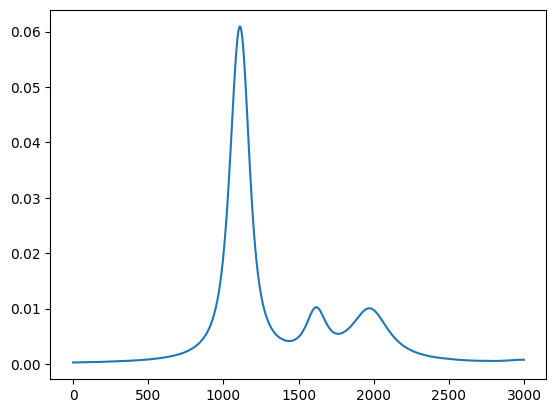

In [97]:
plt.plot(x_dat[1200])

In [98]:
max(x_dat[1200])

0.0609

In [99]:
# ICM model set up
ks = GPy.kern.RBF(np.shape(X_train)[1])
icm = GPy.util.multioutput.ICM(input_dim=np.shape(X_train)[1],num_outputs=1,kernel=ks)

In [100]:
print(icm)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)

  ICM.             |         value  |  constraints  |  priors
  rbf.variance     |           1.0  |      +ve      |        
  rbf.lengthscale  |           1.0  |      +ve      |        
  B.W              |  [0.31829538]  |               |        
  B.kappa          |           0.5  |      +ve      |        


In [101]:
Y_train.shape

(5000, 3)

In [103]:
m = GPy.models.GPCoregionalizedRegression([X_train],[Y_train],kernel=icm)
m['.*rbf.var'].constrain_fixed(1.)
# constrain if converge to reasonless extrema
# m['mixed_noise.Gaussian_noise_0.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_1.variance'].constrain_bounded(0,1e-5)
# m['mixed_noise.Gaussian_noise_2.variance'].constrain_bounded(0,1e-5)
print(m)


Name : gp
Objective : 17964.44341376805
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |         value  |  constraints  |  priors
  ICM.rbf.variance                       |           1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |           1.0  |      +ve      |        
  ICM.B.W                                |  [0.31829538]  |               |        
  ICM.B.kappa                            |           0.5  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |           1.0  |      +ve      |        


In [104]:
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)

In [105]:
m.optimize(messages=True)

In [106]:
with open('gpr_ICM_Norm.pkl', 'wb') as file:
    pickle.dump(m, file)

In [107]:
print(m)
# print('W matrix\n',icm.B.W)
# print('\nkappa vector\n',icm.B.kappa)
# print('\nB matrix\n',icm.B.B)


Name : gp
Objective : 9506.31906563239
Number of Parameters : 5
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.rbf.variance                       |                  1.0  |   +ve fixed   |        
  ICM.rbf.lengthscale                    |  0.27027203349415285  |      +ve      |        
  ICM.B.W                                |        [146.2383707]  |               |        
  ICM.B.kappa                            |    33.52016164622557  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.15737223313509652  |      +ve      |        


In [108]:
newX = X_test

In [109]:
newX = np.concatenate((newX,np.zeros((np.shape(X_test)[0],1))),1)
noise_dict = {'output_index':newX[:,-1].astype(int)}
ys_norm,var=m.predict(newX,Y_metadata=noise_dict)

# Temper_test_=scalerT.inverse_transform(ys)


In [129]:
ys_norm[:,0]

array([ 1.24880349,  0.5518822 , -0.52646024, ...,  1.52531804,
       -1.55898828, -1.62928101])

In [130]:
Y_test[:,0]

array([ 1.24807544,  0.5547002 , -0.5547002 , ...,  1.52542554,
       -1.52542554, -1.66410059])

In [110]:
ys = np.zeros_like(ys_norm)
Y_test_real = np.zeros_like(Y_test)

In [111]:
ys[:, 0] = y_A1_T.inverse_transform(ys_norm[:,0].reshape(-1,1)).ravel()
ys[:, 1] = y_A2_T.inverse_transform(ys_norm[:,1].reshape(-1,1)).ravel()
ys[:, 2] = y_A3_T.inverse_transform(ys_norm[:,2].reshape(-1,1)).ravel()

In [112]:
Y_test_real[:, 0] = y_A1_T.inverse_transform(Y_test[:,0].reshape(-1,1)).ravel()
Y_test_real[:, 1] = y_A2_T.inverse_transform(Y_test[:,1].reshape(-1,1)).ravel()
Y_test_real[:, 2] = y_A3_T.inverse_transform(Y_test[:,2].reshape(-1,1)).ravel()

In [113]:
ys[:,0]-Y_test_real[:,0]

array([ 0.10281367, -0.39795087,  3.9879736 , ..., -0.01518076,
       -4.7396437 ,  4.91713132])

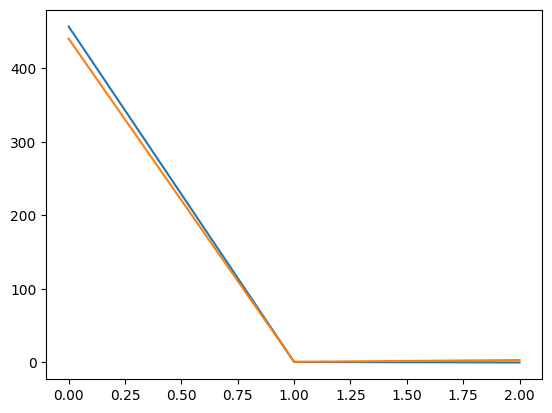

In [144]:
plt.plot(ys[1000])

plt.plot(Y_test_real[1000])

In [140]:
ys-Y_test_real

array([[ 1.02813670e-01,  4.03429042e-02,  2.44753103e-03],
       [-3.97950871e-01, -2.21941371e-02, -5.57607252e-03],
       [ 3.98797360e+00, -1.58732885e-01, -2.04447357e-01],
       ...,
       [-1.51807555e-02,  3.96270991e-02, -1.62922371e-02],
       [-4.73964370e+00, -4.27309717e-01, -5.56797044e+00],
       [ 4.91713132e+00,  2.10628676e-01,  2.50984222e+00]])

In [139]:
Y_test_real

array([[7.14250000e+02, 5.50000000e-01, 4.39795918e+01],
       [6.16333333e+02, 7.75000000e-01, 2.63469388e+01],
       [4.59666667e+02, 7.75000000e-01, 1.31224490e+01],
       ...,
       [7.53416667e+02, 1.00000000e+00, 4.50816327e+01],
       [3.22583333e+02, 1.00000000e+00, 4.17755102e+01],
       [3.03000000e+02, 3.25000000e-01, 2.19387755e+01]])

In [117]:
from sklearn import metrics

In [131]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 1]), np.array(Y_test_real[:, 1]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 0.0362101221616705


In [132]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 2]), np.array(Y_test_real[:, 2]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 11.131885539031625


In [134]:
conc_1 = metrics.mean_squared_error(np.array(ys[:, 0]), np.array(Y_test_real[:, 0]))
print(f'The mean squared error between the real and predicted values are: {conc_1}')

The mean squared error between the real and predicted values are: 139.94571247440814


In [135]:
metrics.mean_squared_error(ys, Y_test_real)

50.37126937853381

In [136]:
np.save("true_vals_icm", Y_test_real)

In [137]:
np.save("pred_vals_icm", ys)
